In [ ]:
#!/usr/bin/env python                                                                                            
# coding: utf-8                                                                                                  
                                                                                                                 
from networkx import networkx as nx                                                                              
from itertools import combinations                                                                               
from collections import defaultdict                                                                              
import matplotlib.pyplot as plt                                                                                  
import scipy                                                                                                     
import os                                                                                                        
import json                                                                                                      
import database_handler                                                                                          
#from data_reader import get_stackoverflow_data                                                                  
                                                                                                                 
BASE_PATH = 'data'                                                                                               
                                                                                                                 
G=nx.Graph()                                                                                                     
                                                                                                                 
#xml_dict = get_stackoverflow_data(f"{BASE_PATH}/bitcoin")                                                       
                                                                                                                 
# example on how to use the xml                                                                                  
#for row in xml_dict['Users'][:2]:                                                                               
#    # row objects have tag & attrib                                                                             
#    print(row.tag, row.attrib)                                                                                  
                                                                                                                 
# Extraction of features into individual json files for each directory                                           
database_handler.prepare_json_databases(BASE_PATH)                                                               
                                                                                                                 
G.add_nodes_from(os.listdir(BASE_PATH))                                                                          
                                                                                                                 
edges = defaultdict(lambda:defaultdict(int))                                                                     
# Each directory represents a site                                                                               
for dir1, dir2 in combinations(os.listdir(BASE_PATH), 2):                                                        
    users1 = database_handler.load_json_database(BASE_PATH, dir1)                                                
    users2 = database_handler.load_json_database(BASE_PATH, dir2)                                                
    # The weight of the edge is the number of users that have posted in both sites                               
    for user in set(users1).intersection(set(users2)):                                                           
        edges[(dir1, dir2)]['weight'] += 1                                                                       
# Networkx doesn't seem to handle defaultdicts, hence the following generator                                    
G.add_weighted_edges_from((k[0], k[1], v['weight']) for k, v in edges.items())                                   
                                                                                                                 
# Drawing edge thickness according to width                                                                      
plt.figure(1, figsize=(12,12))                                                                                   
weights = [G[i][j]['weight']/500 for i, j in edges]                                                              
nx.draw(G, with_labels=True, node_color='skyblue', width=weights)                                                
plt.show() 

In [7]:
#!/usr/bin/env python
# coding: utf-8

from networkx import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy
import os
from data_reader import get_stackoverflow_data

BASE_PATH = 'data'

G = nx.DiGraph()

edges = dict()
missing_users = set()
nodes = defaultdict(dict)
for directory in os.listdir(BASE_PATH):
    print('Searching', directory)
    posts_dict = dict()
    users = defaultdict(dict)
    xml_data = get_stackoverflow_data(os.path.join(BASE_PATH, directory), ['Posts', 'Users'])
    for user in xml_data['Users']:
        account_id = user.attrib.get('AccountId', user.attrib.get('DisplayName'))
        # Wanted features
        reputation = user.attrib.get('Reputation')
        users[account_id]['Reputation'] = reputation
    for found_user in missing_users & set(users):
        nodes[found_user] = users[found_user]
        missing_users.remove(found_user)
    for row in xml_data['Posts']:
        user_id = row.attrib.get('OwnerUserId', row.attrib.get('OwnerDisplayName'))
        # PostTypeId == 1 indicates that it's a question
        if row.attrib['PostTypeId'] == '1':
            posts_dict[row.attrib['Id']] = user_id
        # otherwise it's an answer to an existing question
        elif row.attrib['PostTypeId'] == '2':
            # fetches the id of the OP and links them
            parent_user_id = posts_dict.get(row.attrib['ParentId'])
            creation_date = row.attrib.get('CreationDate')
            for user in user_id, parent_user_id:
                if not user:
                    break
                try:
                    # Checking the specific value in order not to trigger defaultdict
                    nodes[user]['Reputation'] = users[user]['Reputation']
                except KeyError:
                    if user not in nodes:
                        missing_users.add(user)
            # in case both user ids are known, add an edge
            else:
                # setdefault seems to be faster than defaultdict in this case
                edges.setdefault((user_id, parent_user_id), dict())[directory] = []
                edges[(user_id, parent_user_id)][directory].append(creation_date)


nodes.update({user: None for user in missing_users})
G.add_edges_from([(k[0], k[1], {k2:','.join(v2)}) for k, v in edges.items() for k2, v2 in v.items()])
#G.add_edges_from(edges)
G.add_nodes_from(nodes)

Searching bitcoin


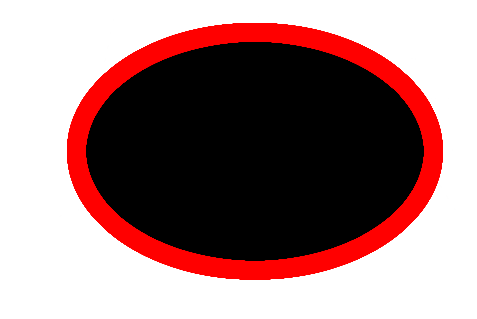

In [10]:
plt.figure(1, figsize=(16,16))
#nx.draw(G, with_labels=True, node_color='skyblue', width=weights)
#plt.show()
#nx.write_graphml(G, "stack.graphml")

nx.draw_circular(G)

In [12]:
closeness = nx.algorithms.closeness_centrality(G)

In [40]:
nodes_with_reputation = { k:int(v['Reputation']) for k, v in nodes.items() if v }
node_closeness = { k: closeness[k] for k in nodes_with_reputation }

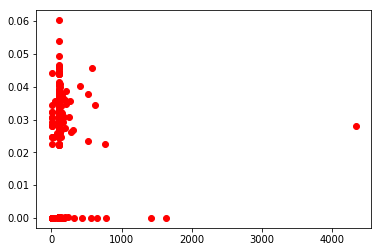

In [41]:
ks = sorted(nodes_with_reputation, key=nodes_with_reputation.get)
f = plt.figure()
plt.plot([nodes_with_reputation[k] for k in ks], [node_closeness[k] for k in ks], 'ro')
plt.show()
f.savefig("plot.pdf", bbox_inches='tight')

In [47]:
ks
sum(1 for k in nodes_with_reputation.values() if k == 101) / len(nodes_with_reputation)

0.7121848739495799